In [2]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [4]:
#f = r.TFile("./deltaTCalos.root")
#f = r.TFile("./data/Dec20_withEnergyAndIntraCalib_deltaT_vs_calo.root")
f = r.TFile("./data/post_disk/deltaTCalos_EnergyCorrected_IntraCaloCorrected_postDisk.root")
f.ls()
c1 = f.Get("c1")
print([x for x in c1.GetListOfPrimitives()])
#deltaTCalos = c1.GetPrimitive("hist2").Clone()
deltaTCalos = c1.GetPrimitive("deltaTCalos").Clone()
#deltaTCalos = c1.GetPrimitive("hist").Clone("deltaTCalos")
deltaTCalos.SetDirectory(0)

[<ROOT.TFrame object ("TFrame") at 0x7fffdb654220>, <ROOT.TH2D object ("deltaTCalos") at 0x7fffdb668a50>, <ROOT.TPaveText object ("title") at 0x7fffdbb01a80>]
TFile**		./data/post_disk/deltaTCalos_EnergyCorrected_IntraCaloCorrected_postDisk.root	
 TFile*		./data/post_disk/deltaTCalos_EnergyCorrected_IntraCaloCorrected_postDisk.root	
  KEY: TCanvas	c1;1	c1


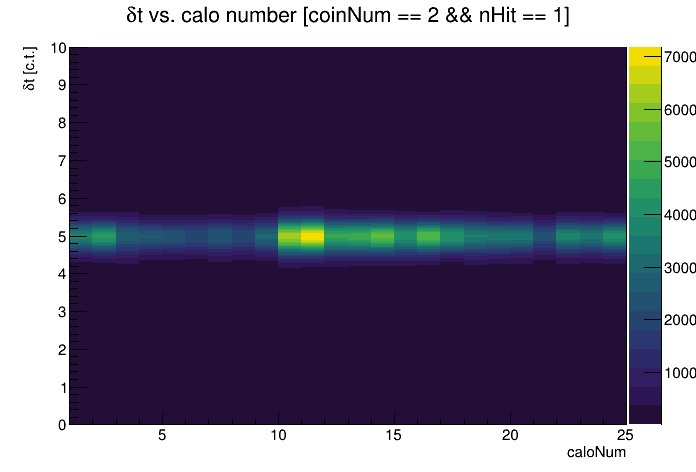

In [5]:
c = r.TCanvas()
deltaTCalos.Draw("colz")
c.Draw()

In [6]:
excludeCalos = []
nCalos = 24#-len(excludeCalos)
print("Excluding calo(s):", excludeCalos)

Excluding calo(s): []


In [7]:
shape = (1,nCalos+1) #shape of each row in the calorimeter matrix. 24 rows for calos + 1 for setting calo 22 offset to 0.

#create a matrix in which to store the calo values and the deltaT value
matrix = np.zeros(shape, dtype=float)
rhs = np.zeros((1,1),dtype=float)
#print(matrix, len(matrix[0]))
#print(rhs)

caloHists = []
dumbConstants = []

for calo in range(1,25):
    caloBin = deltaTCalos.GetXaxis().FindBin(calo)
    hi = deltaTCalos.ProjectionY("",caloBin, caloBin).Clone("h_"+str(calo))
    hi.SetTitle("Uncorrected Calo "+str(calo))
    c = r.TCanvas()
    hi.Draw()
    
    peak = hi.GetBinCenter(hi.GetMaximumBin())
    maxValue = hi.GetBinContent(hi.GetMaximumBin())
    tempSigma = 0.4 #hi.GetRMS()
    
    func = r.TF1("func","gaus",peak-tempSigma, peak+tempSigma)
    func.SetParameters(maxValue,peak,0.5)
    func.SetParLimits(1,peak*0.9, peak*1.1)
    func.SetParLimits(0,maxValue*0.9, maxValue*1.1)
    for sdfniwe in range(2):
        hi.Fit(func,"REMBQ")
    
    caloHists.append(hi.Clone("hi_"+str(calo)))
    #c.Draw()
    
    mean = func.GetParameter(1)
    dumbConstants.append(mean)
    #if(calo == 9):
    #    mean -= 2
    
    if(calo not in excludeCalos):
        #create a new row in each of the matrices and set the values accordingly
        newMatrixRow = [[0 for i in range(nCalos)]+[1]]
        #newMatrixRow[0][(calo -1) % 24] = 1
        #newMatrixRow[0][calo % 24] = -1
        newMatrixRow[0][(calo - 2) % nCalos] = -1
        newMatrixRow[0][(calo - 1) % nCalos] = 1
        newRHS = [[mean]]
        #print(newMatrixRow)

        matrix = np.append(matrix, newMatrixRow, 0)
        rhs = np.append(rhs, newRHS, 0)

        #create condition to set calo 22 to 0
    if(calo == 22 or calo in excludeCalos): 
        newMatrixRow = [[0 for i in range(nCalos)]+[0]]
        newMatrixRow[0][(calo -1) % nCalos] = +1
        newRHS = [[0]]
        #print(newMatrixRow)
        matrix = np.append(matrix, newMatrixRow, 0)
        rhs = np.append(rhs, newRHS, 0)

matrix = np.delete(matrix, 0, 0)
rhs = np.delete(rhs, 0, 0)

In [8]:
refCalo = 22
TcOver24 = 6.217 #ns
#refConst = dumbConstants[refCalo - 1]
refConst = TcOver24/1.25
for i, c in enumerate(dumbConstants):
    #print(c - dumbConstants[refCalo - 1])
    dumbConstants[i] = refConst - c

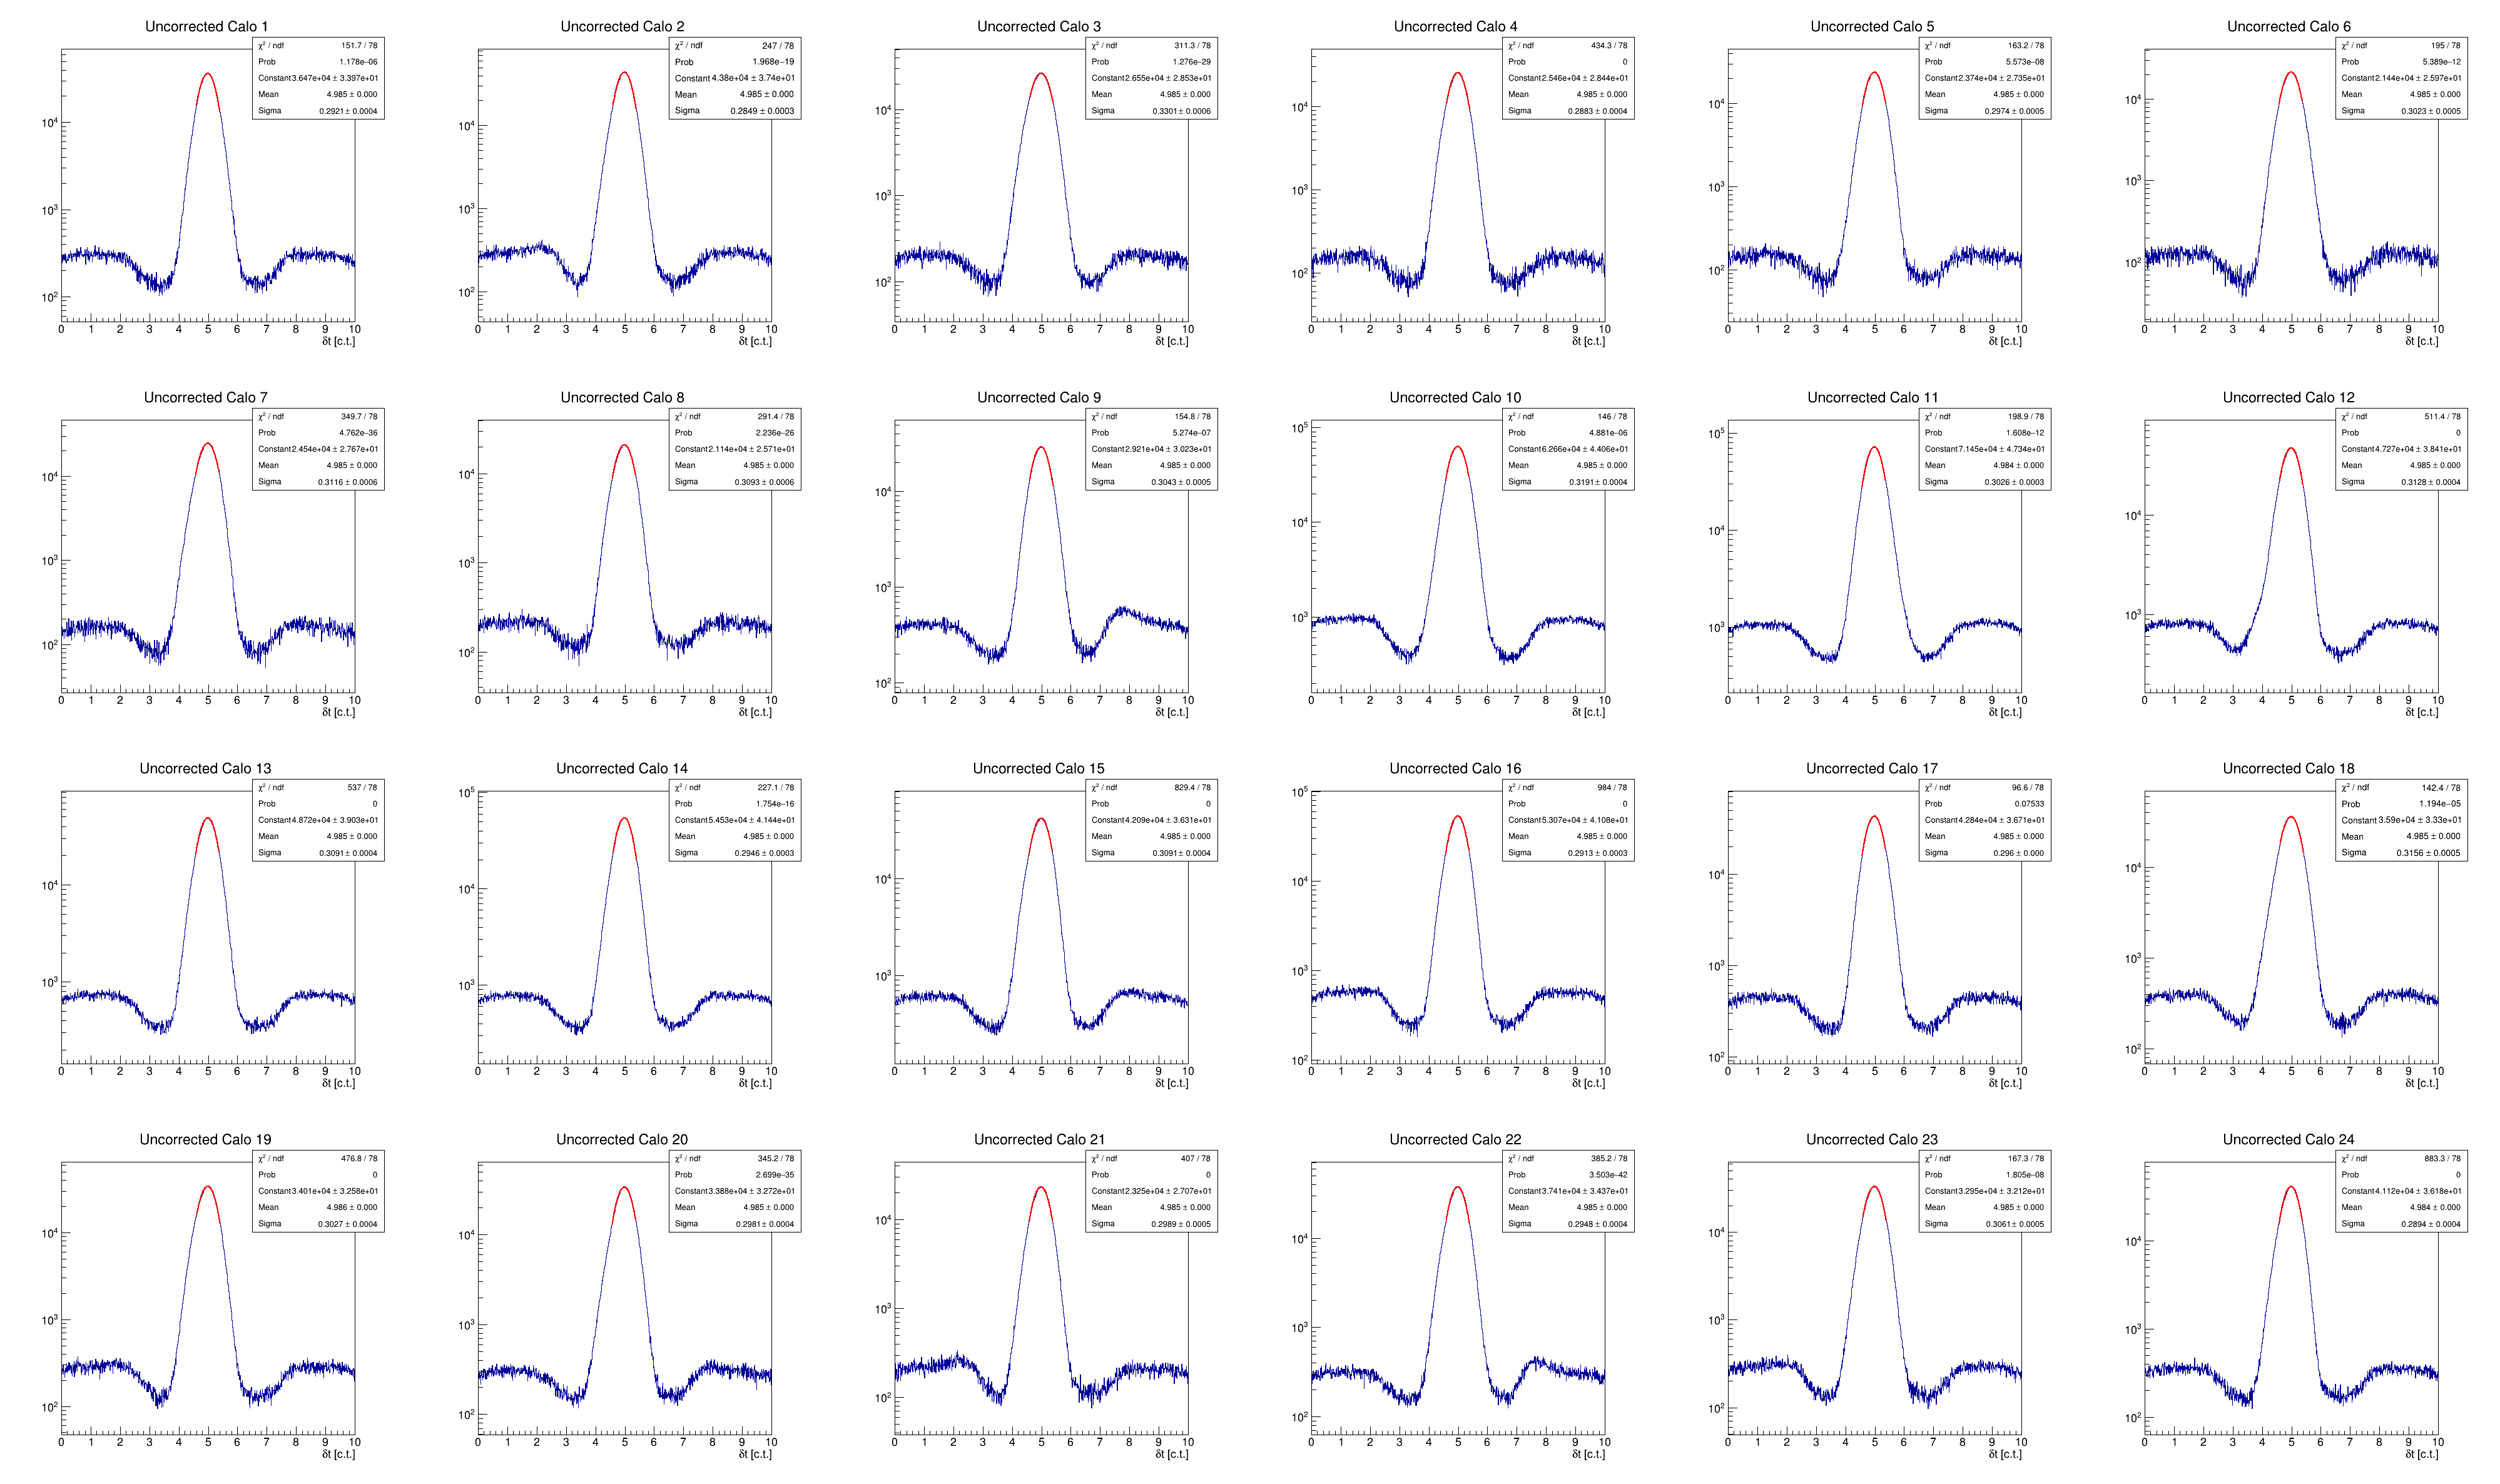

In [9]:
c = r.TCanvas("c","c",4000,2400)
c.Divide(6,4)
for i, h in enumerate(caloHists):
    c.cd(i+1)
    h.Draw()
    r.gPad.SetLogy()
c.Draw()

In [10]:
timeConstantsPartial, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)

#invert time constants to match conventions and add back in excluded calos (with constants of 0)
timeConstants = []
#print(timeConstantsPartial)
for i, x in enumerate(list(timeConstantsPartial)):
    #if( i+1 in excludeCalos ):
    #    print("hi", i+1)
    #    timeConstants.append(0)
    timeConstants.append(-1*x[0])
#timeConstants = [-1*x for x in timeConstants]

/home/jlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [11]:
print(timeConstants)

[0.0004424180754163561, 0.0004004779774894056, 0.00033399202375113037, 0.00020331247651944406, 0.00016380876630456612, 0.00040474463999853275, 0.0002622910701893965, 0.000532142114347256, 0.00044432459680888146, 0.0004900031464235322, 0.0009928972543977303, 0.0008543104437269723, 0.0012068635583378784, 0.0012368370296393996, 0.001202316737151702, 0.001244026110660887, 0.0011748733832375592, 0.0011964825492357045, 0.00014600130831939363, 4.13749046522948e-05, 0.00019888835819349335, 3.1555704230190607e-15, -0.00045141718977400615, 0.0005338084450418632, -4.984957125082823]


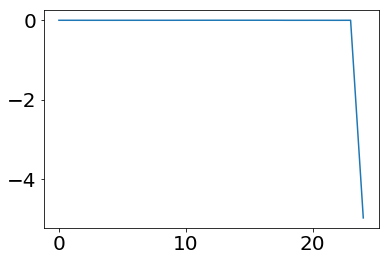

In [12]:
plt.plot(timeConstants)

In [13]:
print("Global delta t offset =", -1*timeConstants[len(timeConstants) - 1],"c.t.")
print("                      =", -1*timeConstants[len(timeConstants) - 1]*1.25,"ns")
print("             T_{c}/24 =","6.217 ns")

Global delta t offset = 4.984957125082823 c.t.
                      = 6.231196406353528 ns
             T_{c}/24 = 6.217 ns


In [14]:
#calculated on the virtual machines using jasons timing alignment constant values
jasonConstants = [-0.373,0.000,-0.220,-0.271,0.675,0.095,0.498,0.624,-1.168,-1.380,-1.018,-1.209,-0.490,-0.354,-0.143,-0.307,-0.846,
                  -0.670,-0.528,-0.724,0.434,-0.000,0.273,-0.044,-5.051]

In [15]:
with open('globalTimeAlignmentConstants.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for x in timeConstants:
    #for x in dumbConstants:
        spamwriter.writerow([x])

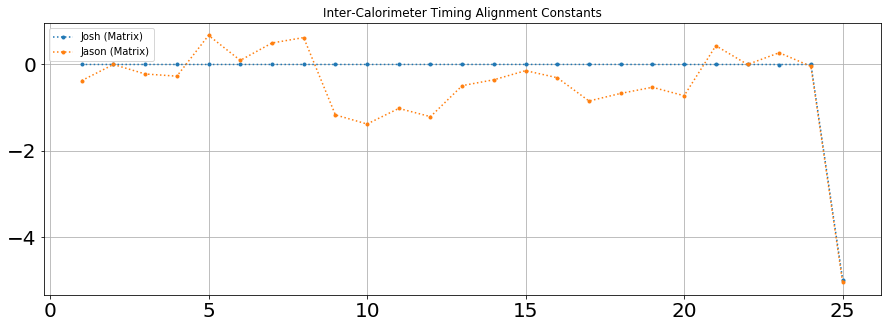

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot([x for x in range(1,26)],[float(x) for x in timeConstants], ".:",label="Josh (Matrix)")
#plt.plot([x for x in range(1,25)],dumbConstants,".:",label="Josh (Means)")
plt.plot([x for x in range(1,26)],jasonConstants,".:",label="Jason (Matrix)")
plt.title("Inter-Calorimeter Timing Alignment Constants")
plt.legend()
plt.grid()
plt.show()

In [16]:
deltaConstants = [float(x)-y for (x,y) in zip(timeConstants,jasonConstants)]
print(deltaConstants)

[0.06202651556298966, -0.07237127788818551, -0.026071830329713025, -0.008196066386096934, -0.13902594240400645, 0.33783369651325357, -0.17002737044510685, -0.0436518045495512, -0.12091305962884502, -0.019578714739515446, -0.09633801942551745, 0.10204131338512212, -0.015333376292688494, -0.027724256333818142, 0.0511561723781552, 0.08059879174160736, 0.11355116674289523, 0.16512411905410773, 0.03202352212211407, 0.16493876340024816, 0.030862290614423527, 5.079270337660091e-15, -0.04613088179522387, 0.08672030896320473, 0.0660347707240021]


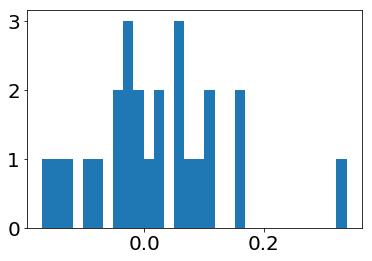

In [17]:
plt.hist(deltaConstants,bins=30)
plt.show()

In [18]:
#f2 = r.TFile("./data/gm2offline_full_allRuns_EnergyFix.root")
f2 = r.TFile("./data/lostMuons_WithEnergyCalibration_WithIntraCaloTimingCorrection.root")
f2.ls()
t = f2.Get("lostMuonTree/lostMuonCoincidences")
#t.Print()

TFile**		./data/lostMuons_WithEnergyCalibration_WithIntraCaloTimingCorrection.root	
 TFile*		./data/lostMuons_WithEnergyCalibration_WithIntraCaloTimingCorrection.root	
  KEY: TDirectoryFile	lostMuonTree;1	lostMuonTree (LostMuonTree) folder
